In [65]:

from utils import *

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the dataset

In [67]:


# CIFAR-10 data loading and transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


## Loading the Resnet18 Model

In [68]:
from torchvision.models import resnet18

model = resnet18(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()

## Training on the CIFAR10 Dataset using quantized dataset 

In [71]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Training loop with quantization
num_epochs = 20
quantization_bits = 8  # Adjust this for different levels of quantization


train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in trainloader:
        inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Quantize gradients
        for param in model.parameters():
            if param.grad is not None:
                param.grad = add_sparsity(param.grad, 0.4)

        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
    train_losses.append(running_loss / len(trainloader))


    # Validate the model
    model.eval()
    correct = 0
    total = 0

    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(100 * correct / total)


print('Finished Training')


Epoch 1, Loss: 1.9661501517990971
Accuracy: 47.94%
Epoch 2, Loss: 1.2552357986759957
Accuracy: 59.87%
Epoch 3, Loss: 1.0194878378487608
Accuracy: 63.6%
Epoch 4, Loss: 0.8931685651049894
Accuracy: 67.6%
Epoch 5, Loss: 0.8000629227179701
Accuracy: 68.73%
Epoch 6, Loss: 0.7346040861076101
Accuracy: 69.31%
Epoch 7, Loss: 0.6899492364100483
Accuracy: 68.92%
Epoch 8, Loss: 0.6399541179389905
Accuracy: 71.13%
Epoch 9, Loss: 0.6039803849004418
Accuracy: 71.34%
Epoch 10, Loss: 0.5654595162709961
Accuracy: 70.35%
Epoch 11, Loss: 0.54966237759956
Accuracy: 72.05%
Epoch 12, Loss: 0.526620193591813
Accuracy: 71.93%
Epoch 13, Loss: 0.49779172329341664
Accuracy: 71.22%
Epoch 14, Loss: 0.4872874463610637
Accuracy: 72.11%
Epoch 15, Loss: 0.47014112679092473
Accuracy: 72.82%
Epoch 16, Loss: 0.45751786022387503
Accuracy: 73.17%
Epoch 17, Loss: 0.4455746123400491
Accuracy: 72.14%
Epoch 18, Loss: 0.4411628347299898
Accuracy: 73.52%
Epoch 19, Loss: 0.42979294541851637
Accuracy: 73.24%
Epoch 20, Loss: 0.4188

## Logging the train, test losses and test accuracy

In [74]:

d["sparse_40"] = {"train_losses": train_losses, "test_losses": test_losses, "test_accuracies": test_accuracies}

In [75]:
d.keys()

dict_keys(['uniform_16', 'normal', 'stochastic_16', 'sparse_20', 'sparse_40'])

In [77]:
name = {'uniform_16': 'Uniform Quantization (16)',
         'normal': 'No quantization',
         'stochastic_16': 'Stochastic Quantization (16)',
        'sparse_20':'Sparsity compression (20%)',
        'sparse_40':'Sparsity compression (40%)'
        }

colour = {'uniform_16': 'b',
         'normal': 'g',
         'stochastic_16': 'r',
        'sparse_20':'y',
        'sparse_40':'c'
        }

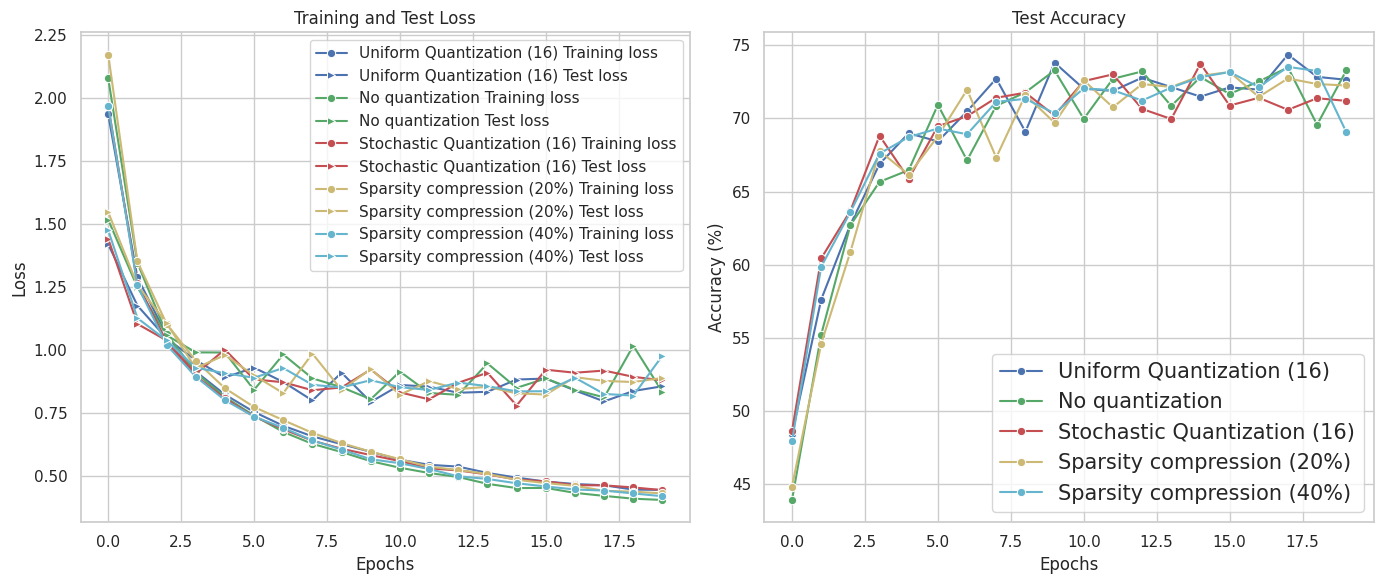

In [84]:
epochs = range(num_epochs)
    
sns.set(style="whitegrid")

plt.figure(figsize=(14, 6))


for k in d.keys():
    # Plot loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=d[k]['train_losses'], label=f'{name[k]} Training loss', color=colour[k], marker='o')
    sns.lineplot(x=epochs, y=d[k]['test_losses'], label=f'{name[k]} Test loss', color=colour[k], marker='>')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

for k in d.keys():
    # Plot loss
    sns.lineplot(x=epochs, y=d[k]['test_accuracies'],color=colour[k], marker='o', label=f'{name[k]}')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(fontsize=15)

plt.tight_layout()

plt.savefig(f'images/Accuracy.png')
plt.show()

Dummy label is 58.


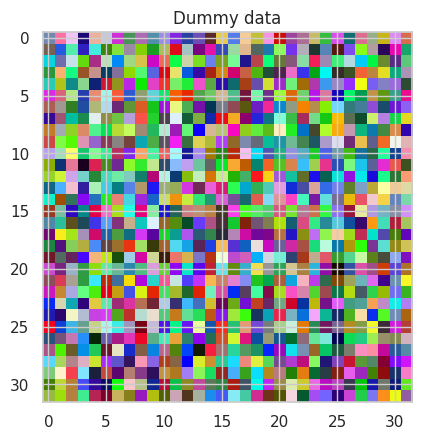

In [84]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

gt_data = tp(Image.open('images/me.jpg')).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([5]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

criterion = cross_entropy_for_onehot

dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())


In [94]:
def reconstruct(model, original_dy_dx, data_size, label_size):

    # generate dummy data and label
    dummy_data = torch.randn(data_size).to(device).requires_grad_(True)
    dummy_label = torch.randn(label_size).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    history = []
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

    for iters in range(300):
        def closure():
            optimizer.zero_grad()
    
            pred = model(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)
    
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()
    
            return grad_diff
    
        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))


    
    history_tensors = [tp(img).to(device) for img in history]
    
    # Convert ground truth image to tensor
    gt_tensor = gt_data[0].to(device)
    
    # Calculate L2 loss
    l2_losses = []
    plt.figure(figsize=(12, 8))
    for img_tensor in history_tensors:
        l2_losses.append(torch.nn.L1Loss()(img_tensor, gt_tensor).item())
    
    # Print the total L2 loss
    sns.lineplot(x=range(len(l2_losses)), y=l2_losses)
    plt.title("L1 Loss")
    plt.show()

    plt.figure(figsize=(12, 8))
    for i in range(30):
      plt.subplot(3, 10, i + 1)
      plt.imshow(history[i * 10])
      plt.title("iter=%d" % (i * 10))
      plt.axis('off')

    plt.show()
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())